In [18]:
import numpy as np
import pandas as pd
import requests 
import apimoex
import matplotlib.pyplot as plt

from helper import get_data

In [2]:
TICKER_NAME = 'GAZP'
alphas = [0.01, 0.05, 0.95, 0.99]
interval = 24

start_date = '2022-10-18'
end_date = '2023-10-18'

In [3]:
df = get_data(TICKER_NAME, start_date, end_date, interval)
df.head()
df.tail()

,begin,open,close,high,low,value
250,2023-10-12 00:00:00,167.90,169.50,169.80,167.40,5.381001e+09
251,2023-10-13 00:00:00,169.90,170.20,170.79,167.15,6.540513e+09
252,2023-10-16 00:00:00,170.50,172.55,172.91,170.50,7.158742e+09
253,2023-10-17 00:00:00,172.75,171.97,173.30,171.03,4.603961e+09
254,2023-10-18 00:00:00,172.67,170.18,172.68,168.70,5.460248e+09


In [82]:
def log_income(df: pd.DataFrame):
    """
        marh:: `r_i(t) = ln(\frac{close_i(t)}{close_i(t-1)})`
    """
    income_vec = np.zeros(len(df))

    for i in range(1, len(df)):
        income_vec[i] += np.log(df.loc[i, 'close'] / df.loc[i-1, 'close'])

    return income_vec

In [96]:
income_vec = log_income(df)
incomve_vec = np.where(income_vec == .0, 1e-12, income_vec)
income_vec.shape

(255,)

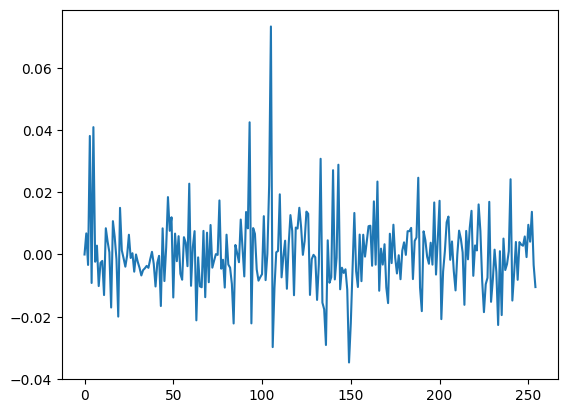

In [106]:
plt.plot(income_vec)
plt.show()

VaR - Value at Risk

CVar - Conditional Value at Risk

In [152]:
alphas = [0.01, 0.05, 0.95, 0.99]

In [98]:
expected = income_vec.mean()  # как оценка случайной величины
std = (((income_vec - expected)**2).sum() / (len(income_vec) - 1))**0.5
expected, std

(0.00023699476779275608, 0.012190870099023)

In [223]:
kvantile = alpha_to_kvantile[0.01]
var = kvantile * std + expected

In [224]:
svr_tomorrow = (var + 1) * income_vec # df['close'].values

In [225]:
svr_in_weak = (var*np.sqrt(5) + 1) * income_vec # df['close'].values

In [226]:
cost_dicrease_risk_1d = svr_tomorrow - income_vec # df['close'].values
cost_dicrease_risk_1wk = svr_in_weak - income_vec # df['close'].values

In [227]:
percent_risk_1d = cost_dicrease_risk_1d / income_vec # df['close'].values
percent_risk_1wk = cost_dicrease_risk_1wk / income_vec # df['close'].values

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_40209/2552859571.py:1: RuntimeWarning: invalid value encountered in divide
  percent_risk_1d = cost_dicrease_risk_1d / income_vec # df['close'].values
/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_40209/2552859571.py:2: RuntimeWarning: invalid value encountered in divide
  percent_risk_1wk = cost_dicrease_risk_1wk / income_vec # df['close'].values


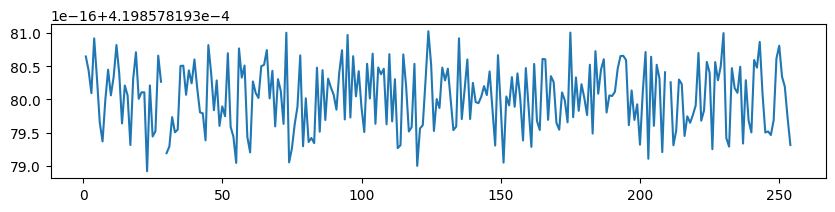

In [228]:
plt.figure(figsize=(10,2))
plt.plot(percent_risk_1d)
plt.show()

In [229]:

def calculate_var_alpha(df, alpha, period=-1, income_strategy='log'):

    alpha_to_kvantile = {'0.01': 0.015, '0.05': 0.06, '0.95': 1.96, '0.99': 2.56}
    
    def _process_var_alpha(close_prices, income_strategy, alpha, period=-1):
        
        if income_strategy == 'log':
            income_vec = _get_log_income_vec(close_prices)
        elif income_strategy == 'classic':
            pass

        if period == -1 or period == len(close_prices):
            expected, std = _get_expected_value_and_std(income_vec)
            kvantile = alpha_to_kvantile[f'{1-alpha:.2f}']
            var = kvantile * std + expected
            return var
            
        elif period >= 1 and period < len(close_prices):
        
            expected, std = np.zeros(len(close_prices)), np.zeros(len(close_prices))
            for i in range(period, len(close_prices), 1):
                _expected, _std = _get_expected_value_and_std(income_vec[i-period: i])
                expected[i] += _expected
                std[i] += _std

            vars = np.zeros(len(close_prices))
            for idx, (_exp, _std) in enumerate(zip(expected, std)):
                kvantile = alpha_to_kvantile[f'{1-alpha:.2f}']
                vars[idx] += kvantile * _std + _expected

            return vars
        else:
            raise ValueError
                

    def _get_log_income_vec(close_prices):
        """
            marh:: `r_i(t) = ln(\frac{close_i(t)}{close_i(t-1)})`
        """
        income_vec = np.zeros(len(close_prices))
    
        for i in range(1, len(df)):
            income_vec[i] += np.log(df.loc[i, 'close'] / df.loc[i-1, 'close'])
    
        return income_vec

    def _get_expected_value_and_std(income_vec):
        expected = income_vec.mean()  # как оценка случайной величины
        std = (((income_vec - expected)**2).sum() / (len(income_vec) - 1))**0.5
        return expected, std


    if len(alpha) == 1:
        var = _process_var_alpha(df['close'].values, income_strategy, alpha[0], period)
        return var
    elif len(alpha) > 1:
        vars_per_alpha = []
        for _alpha in alpha:
            vars_per_alpha.append(_process_var_alpha(df['close'].values, income_strategy, _alpha, period))

        return vars_per_alpha
    else:
        raise ValueError

In [230]:
var = calculate_var_alpha(df, [0.01])
var

0.03144562222129164

In [231]:
var = calculate_var_alpha(df, [0.01], period=21)
var.shape

(255,)

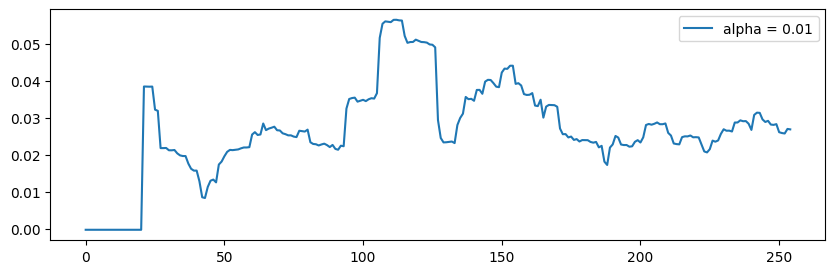

In [232]:
plt.figure(figsize=(10, 3))
plt.plot(var, label='alpha = 0.01')
plt.legend()
plt.show()

In [233]:
var = np.array(calculate_var_alpha(df, alphas, period=21))
var.shape

(4, 255)

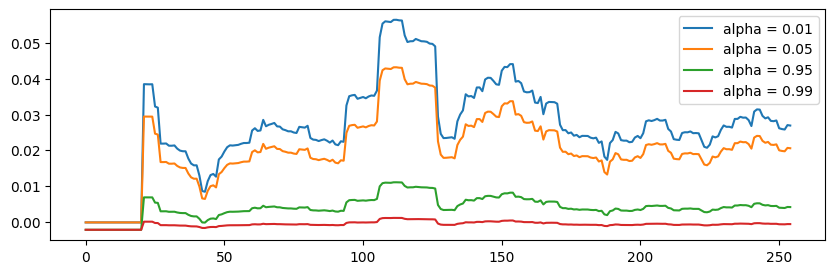

In [234]:
plt.figure(figsize=(10,3))
for (_var, _alpha) in zip(var[0:2], alphas[0:2]):
    plt.plot(_var, label=f'alpha = {_alpha}')

for (_var, _alpha) in zip(var[2:], alphas[2:]):
    plt.plot(_var * 10, label=f'alpha = {_alpha}')

plt.legend()
plt.show()

In [235]:
def calculate_cvar_alpha(df, var, period=-1, income_strategy='log'):
    """
        math:: `$\CVaR_\alpha = E[x|x<VaR_\alpha]$`
    """

    def _get_log_income_vec(close_prices):
        """
            marh:: `r_i(t) = ln(\frac{close_i(t)}{close_i(t-1)})`
        """
        income_vec = np.zeros(len(close_prices))
    
        for i in range(1, len(df)):
            income_vec[i] += np.log(df.loc[i, 'close'] / df.loc[i-1, 'close'])
    
        return income_vec

    close_prices = df['close'].values
    
    if income_strategy == 'log':
            income_vec = _get_log_income_vec(close_prices)
    elif income_strategy == 'classic':
        pass
    
    if period == -1 or period == len(income_vec):
        sub_income = np.where(income_vec <= var, income_vec, 0)
        return sub_income.mean()
    elif period > 1 and period < len(income_vec):
        cvars = np.zeros(len(income_vec))
        for i in range(period, len(income_vec)):
            sub_income = income_vec[i-period:i]
            sub_income = np.where(sub_income <= var[i], sub_income, 0)
            if sub_income.sum != 0:
                cvars[i] += sub_income.mean()
        return cvars
    else:
        raise ValueError

In [236]:
var = calculate_var_alpha(df, [0.01])
cvar = calculate_cvar_alpha(df, var)

In [237]:
var, cvar

(0.03144562222129164, -0.0005265934229312049)

In [238]:
var = calculate_var_alpha(df, [0.01], period=21)
cvar = calculate_cvar_alpha(df, var, period=21)

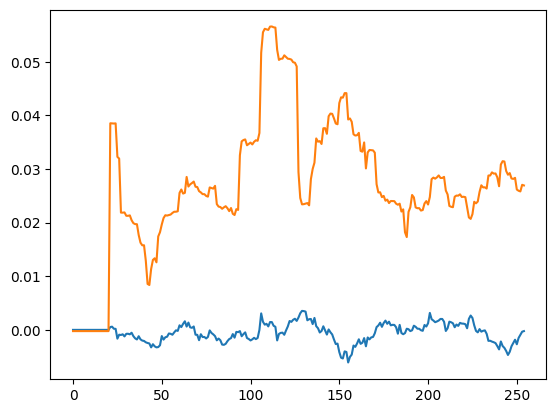

In [239]:
plt.plot(cvar)
plt.plot(var)

In [243]:
var = np.array(calculate_var_alpha(df, alphas, period=21))
print(var.shape)
cvars = []
for _var in var:
    cvars.append(calculate_cvar_alpha(df, _var, period=21))
print(len(cvars))

(4, 255)
4


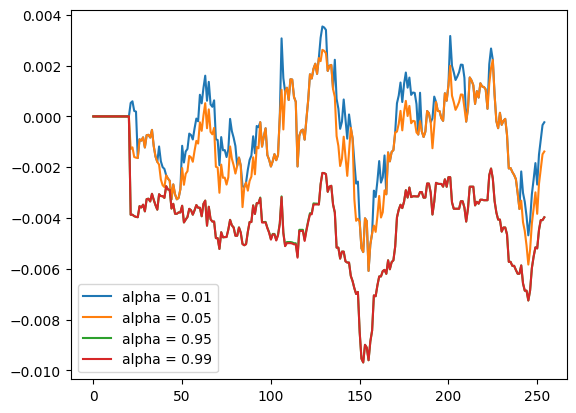

In [245]:
for _cvar, _alpha in zip(cvars, alphas):
    plt.plot(_cvar, label=f'alpha = {_alpha}')

plt.legend()
plt.show()